### Import chipwhisperer and set the scope

The scope can be left as is, because we have only one device connected. In cases where there are multiple divices connected we can use `scope(sn=DEVICE_SERIAL_NUMBER)` to create scope for a specific device. 

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER='SS_VER_2_1'

In [3]:
import chipwhisperer as cw
scope = cw.scope()

In [6]:
scope.dis()

(ChipWhisperer Scope ERROR|File naeusbchip.py:108) Scope already disconnected!


True

Note to self:
When the scope is created, the device's green LED light starts blinking (on top of the blue LED that probably indicates that the device is connected physically).

We also set the scope to a default setup which means:

- Sets the scope gain to 45dB
- Sets the scope to capture 5000 samples
- Sets the scope offset to 0 (aka it will begin capturing as soon as it is triggered)
- Sets the scope trigger to rising edge
- Outputs a 7.37MHz clock to the target on HS2
- Clocks the scope ADC at 4*7.37MHz. Note that this is synchronous to the target clock on HS2
- Assigns GPIO1 as serial RX
- Assigns GPIO2 as serial TX

In [3]:
scope.default_setup()

### Connecting to target

Now we can connect to the target (probably meaning the target board). 

In [4]:
target = cw.target(scope, cw.targets.SimpleSerial2) #cw.targets.SimpleSerial can be omitted
#MY CHANGES - changed target to SimpleSerial2 - to be able to send_cmd

In [ ]:
%%bash
cd makefile_dir/
make PLATFORM='CWLITEARM' CRYPTO_TARGET=NONE > output.txt 2> warning.txt

### Flashing The Compiled .hex Onto Target

In [6]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "makefile_dir/simpleserial-target-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 18971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 18971 bytes


### Capturing a trace

In [23]:
def scope_setup(samples=24431, decimate=2):
    # arm the scope
    scope.arm()
    # Set the maximum number of points in a trace
    scope.adc.fifo_fill_mode = "normal"
    scope.adc.samples = samples
    scope.adc.decimate = decimate


def capture_trace_of(trace_len, input_comp, scope):
    scope_setup(samples=trace_len, decimate=2)
    
    
    # flush the UART buffer
    target.flush()
    
    data = bytearray(input_comp * 16)
    target.send_cmd('p', 0x80, data)
    
    ret = scope.capture()
    trace = scope.get_last_trace()
    
    returned_data = target.read_cmd('r')
    print(returned_data)
    ack = target.read_cmd('e')
    print(ack)
    
    try:
        assert len(trace) == trace_len
        print("✔️ Trace is of targeted lenght!")
    except AssertionError as msg: 
        print("❌ Trace is not of targeted lenght!")
    return trace


In [29]:
zero_trace = capture_trace_of(24431, [0x00], scope)
cw.plot(zero_trace)

CWbytearray(b'00 72 01 00 99 00')
CWbytearray(b'00 65 01 00 eb 00')
✔️ Trace is of targeted lenght!


:Curve   [x]   (y)

In [30]:
trace = capture_trace_of(24431, [0x43], scope)
cw.plot(trace)

CWbytearray(b'00 72 01 00 99 00')
CWbytearray(b'00 65 01 00 eb 00')
✔️ Trace is of targeted lenght!


:Curve   [x]   (y)

In [31]:
cw.plot(trace) * cw.plot(zero_trace)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [35]:
cw.plot(zero_trace) * cw.plot(trace)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [34]:
cw.plot(trace - zero_trace)

:Curve   [x]   (y)

In [16]:
# arm the scope
scope.arm()

# Set the maximum number of points in a trace
scope.adc.fifo_fill_mode = "normal"
scope.adc.samples = 24431
scope.adc.decimate = 2


# flush the UART buffer
target.flush()

data = bytearray([0x42] * 16)
target.send_cmd('p', 0x80, data)

ret = scope.capture()
trace = scope.get_last_trace()

returned_data = target.read_cmd('r')
print(returned_data)
ack = target.read_cmd('e')
print(ack)

CWbytearray(b'00 72 01 00 99 00')
CWbytearray(b'00 65 01 00 eb 00')


In [17]:
print(len(trace))

24431


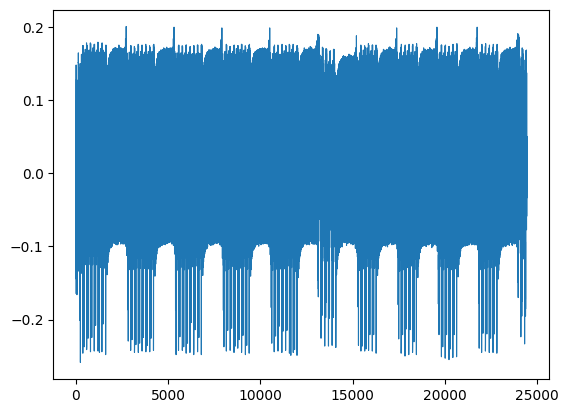

In [18]:
import matplotlib.pyplot as plt
# Plot the trace
plt.plot(trace, linewidth=0.8)

plt.savefig('figure.svg', format='svg')
plt.show()

In [19]:
print(len(trace))

24431


In [20]:
cw.plot(trace)

:Curve   [x]   (y)

In [21]:
print(returned_data)
byte_arr = bytearray(returned_data)
print(byte_arr)


CWbytearray(b'00 72 01 00 99 00')
bytearray(b'\x00r\x01\x00\x99\x00')


### Trying Segmented Capture

In [22]:
scope.arm()
scope.adc.fifo_fill_mode = "segment"
scope.adc.samples = 21000
# flush the UART buffer
target.flush()

data = bytearray([0x42] * 16)
target.send_cmd('p', 0x80, data)
traces = []

ret = scope.capture_segmented()
trace = scope.get_last_trace_segmented()
print("1--")
total_trace = []
print(len(trace))
for t in trace:
    print(len(t))
    for p in t:
        total_trace.append(p)
        
print("2--")
ret = scope.capture_segmented()
trace = scope.get_last_trace_segmented()

print("3--")
print(len(trace))
for t in trace:
    print(len(t))
    for p in t:
        total_trace.append(p)
    
#while captured_points < total_points:
#        
#    ret = scope.capture_segmented()
#    trace = scope.get_last_trace_segmented()
#    
#    traces.append(trace)
#    print(len(trace))
#    captured_points += len(trace)

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:1574) segment mode requires (samples-1) divisible by 3, rounding up to 24433...
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:1574) segment mode requires (samples-1) divisible by 3, rounding up to 21001...
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:642) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08
(ChipWhisperer Scope ERROR|File OpenADC.py:787) Received fewer points than expected: 95 vs 24144


1--
1
21000
2--
3--
0


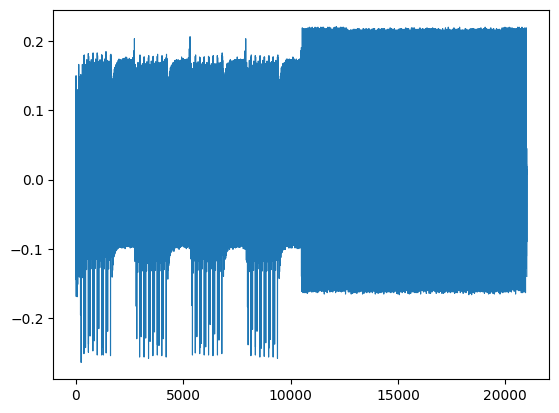

In [12]:
plt.plot(total_trace, linewidth=0.8)

plt.savefig('figure_segmented.svg', format='svg')
plt.show()

### Disconnecting the target and the scope

In [13]:
print(

SyntaxError: unexpected EOF while parsing (149104261.py, line 1)

In [36]:
target.dis()

In [37]:
scope.dis()

True